In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '', addFileNameCol = True)
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 328
The number of rows (Samples): 1845647, The number of columns: 20, number of unique sender id's: (328,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
905528,0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...,NaN,2016-02-12 11:01:25+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,Wallet,0.500000,ETH,0x0000000000000000000000000000000000000000,NaN,2.737825,5.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905527,0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...,NaN,2016-05-11 09:23:12+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,Token,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,499.065146,3.221000e-08,174091.0,74091,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905526,0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...,NaN,2016-05-13 11:44:02+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,26.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.227201,3.221000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905525,0x292d05383a2d9150c5b24718ceef760608561469222f...,NaN,2016-05-19 07:50:40+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,735.916238,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905524,0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...,NaN,2016-05-20 12:29:30+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,100.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1369.368343,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905523,0xde1fb69bc6f78d32413ef8cc800ee4379855636c8daa...,NaN,2016-07-20 13:30:33+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbf4ed7b27f1d666546e30d74d50d173d20bca754,Smart Contract,5000.000000,DAO,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,ERC20,NaN,2.000000e-08,158971.0,43971,NaN,NaN,NaN,0,NaN,Furucombo006.csv
509135,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509134,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509133,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.000000,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509132,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.987191,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [10]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 163887


In [11]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [12]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [13]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [14]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1681760, The number of columns: 20


# Meet the Data

Basic infomration about the data.

In [15]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [16]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [17]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [18]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [19]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [20]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [21]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [22]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [23]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [24]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [25]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [26]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [27]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


In [28]:
sama_ids = dfAttackType[dfAttackType['Attack Type'] == 'SAMASW']['Asset ID'].to_list()
sasa_ids = dfAttackType[dfAttackType['Attack Type'] == 'SASASW']['Asset ID'].to_list()

In [29]:
dfData_sama = dfData[dfData['Sender ID'].isin(sama_ids)]
dfData_sasa = dfData[dfData['Sender ID'].isin(sasa_ids)]

## Features Pre Processing (For Training Phase)

In [30]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [32]:
_df = dfData.groupby(['File Name'])['Transaction ID'].count().reset_index(name = 'Count of TSX')


1681760

In [53]:
n_tsx = 1000
_files =_df[_df['Count of TSX'] > n_tsx ]['File Name'].to_list()

In [54]:
_dfData = dfData[dfData['File Name'].isin(_files)]

In [55]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

_dfData.replace([np.inf, -np.inf], np.nan, inplace = True)
_dfData.fillna(0, inplace = True)
dfX_ = _dfData[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [56]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = _dfData['Label']


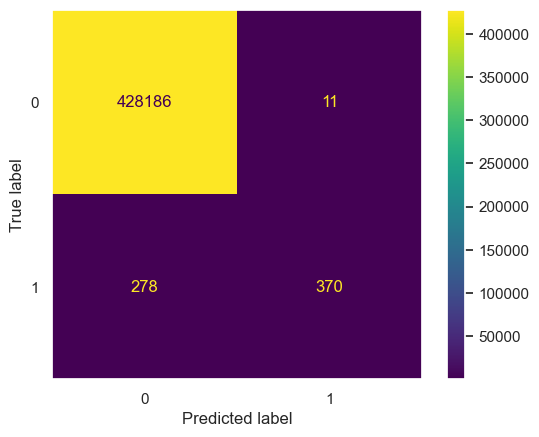

Accuracy         0.999326
F1               0.719145
Precision        0.971129
Recall           0.570988
ROC AUC Score    0.785481
dtype: float64


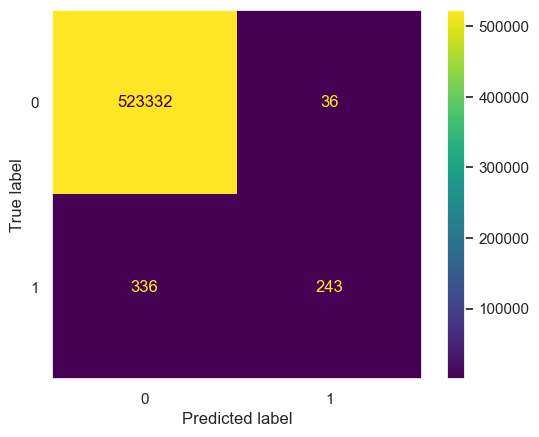

Accuracy         0.999290
F1               0.566434
Precision        0.870968
Recall           0.419689
ROC AUC Score    0.709810
dtype: float64


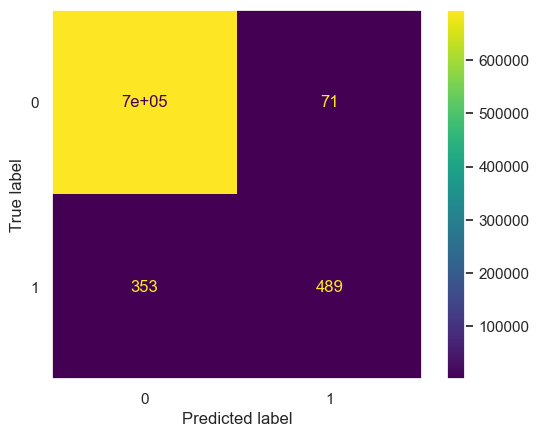

Accuracy         0.999391
F1               0.697575
Precision        0.873214
Recall           0.580760
ROC AUC Score    0.790329
dtype: float64


In [57]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = _dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### K-fold training, using categorical variables (EXPERIMENT)

In [40]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [68]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_sasa.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_sasa.fillna(0, inplace = True)
dfX_ = dfData_sasa[l_sfs].copy()

#for catColName in lCatFeatures:
#    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[l_sfs] = hStdScaler.fit_transform(dfX_[l_sfs])


In [69]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_sasa['Label']


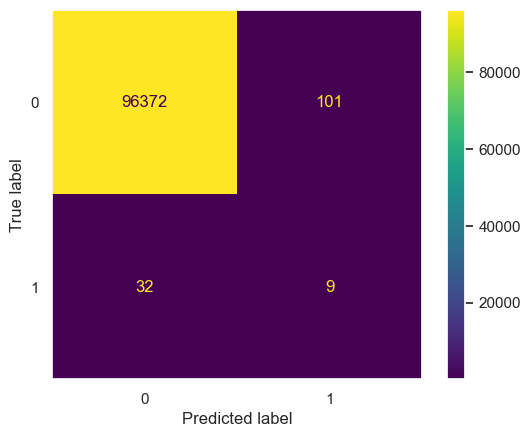

Accuracy         0.998622
F1               0.119205
Precision        0.081818
Recall           0.219512
ROC AUC Score    0.609233
dtype: float64


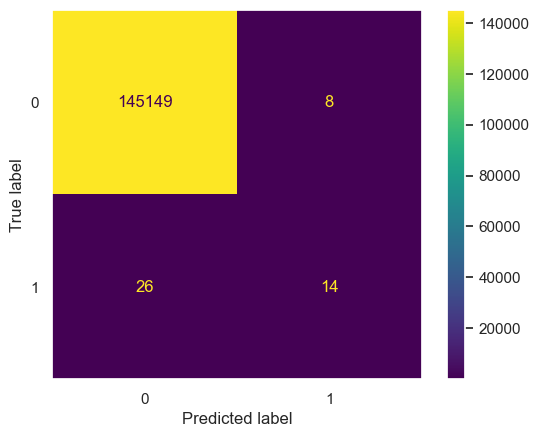

Accuracy         0.999766
F1               0.451613
Precision        0.636364
Recall           0.350000
ROC AUC Score    0.674972
dtype: float64


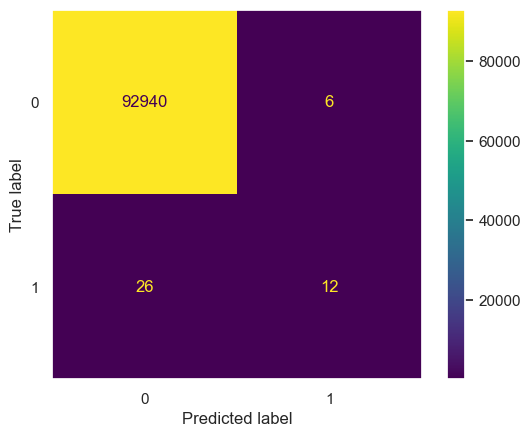

Accuracy         0.999656
F1               0.428571
Precision        0.666667
Recall           0.315789
ROC AUC Score    0.657862
dtype: float64


In [70]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_sasa['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [74]:
_df = dfData_sama.groupby(['File Name'])['Transaction ID'].count().reset_index(name = 'Count of TSX')
n_tsx = 1000
_files =_df[_df['Count of TSX'] > n_tsx ]['File Name'].to_list()
_dfData_sama = dfData_sama[dfData_sama['File Name'].isin(_files)]

In [75]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

_dfData_sama.replace([np.inf, -np.inf], np.nan, inplace = True)
_dfData_sama.fillna(0, inplace = True)
dfX_ = _dfData_sama[l_sfs].copy()

#for catColName in lCatFeatures:
#    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[l_sfs] = hStdScaler.fit_transform(dfX_[l_sfs])


In [76]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = _dfData_sama['Label']


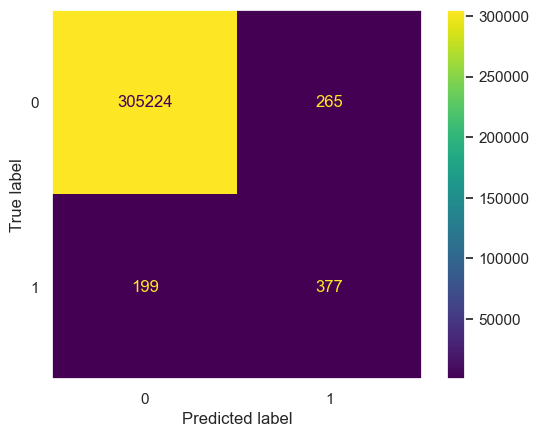

Accuracy         0.998484
F1               0.619048
Precision        0.587227
Recall           0.654514
ROC AUC Score    0.826823
dtype: float64


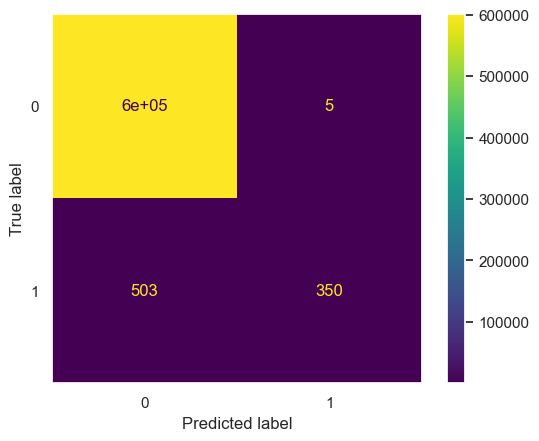

Accuracy         0.999157
F1               0.579470
Precision        0.985915
Recall           0.410317
ROC AUC Score    0.705154
dtype: float64


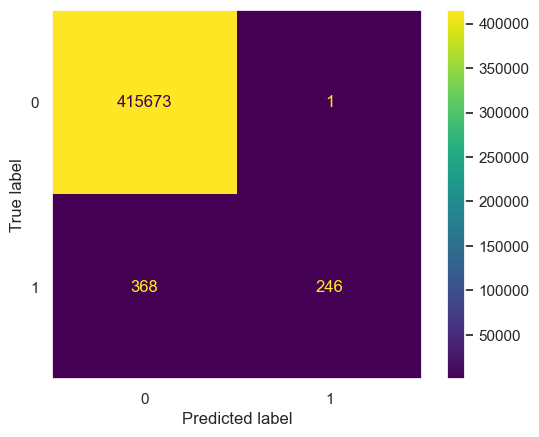

Accuracy         0.999114
F1               0.571429
Precision        0.995951
Recall           0.400651
ROC AUC Score    0.700325
dtype: float64


In [77]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = _dfData_sama['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
#####################################################

In [58]:
l_sfs = ['Amount',
 'Gas Price',
 'Gas Used',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']


In [59]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [62]:
lTotalFeatures = l_sfs 

In [63]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[l_sfs].copy()

#for catColName in lCatFeatures:
#    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[l_sfs] = hStdScaler.fit_transform(dfX_[l_sfs])


In [64]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']

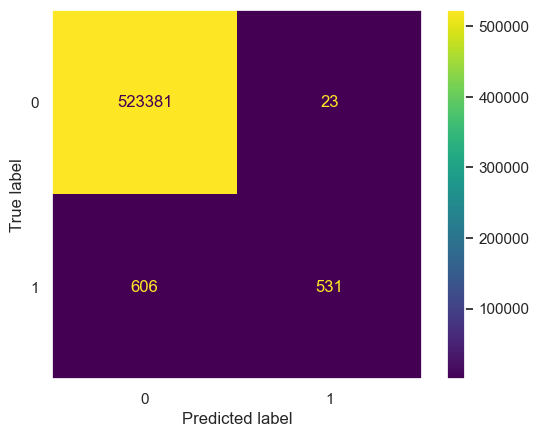

Accuracy         0.998801
F1               0.628031
Precision        0.958484
Recall           0.467018
ROC AUC Score    0.733487
dtype: float64


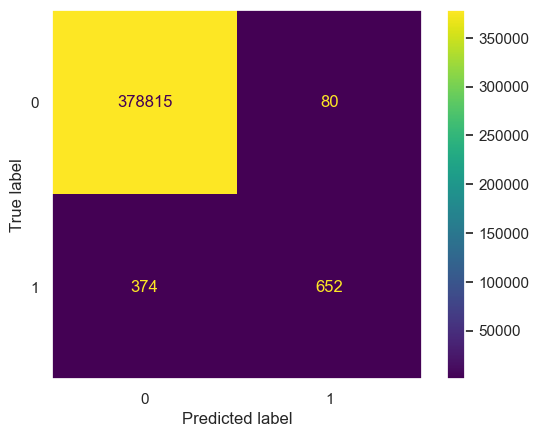

Accuracy         0.998805
F1               0.741752
Precision        0.890710
Recall           0.635478
ROC AUC Score    0.817633
dtype: float64


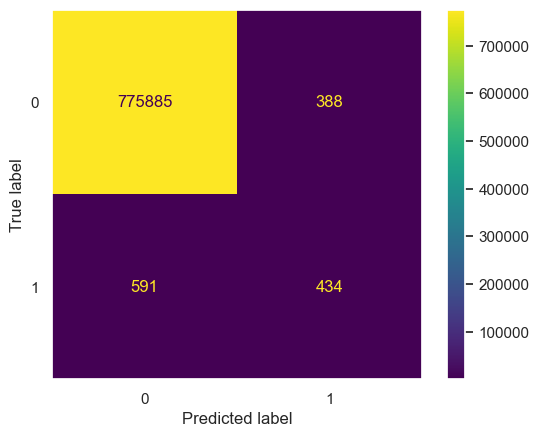

Accuracy         0.998741
F1               0.469951
Precision        0.527981
Recall           0.423415
ROC AUC Score    0.711457
dtype: float64


In [65]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [66]:
(0.467018 + 0.635478 + 0.423415)/3, (0.481091 + 0.634503 + 0.355122)/3

(0.5086369999999999, 0.49023866666666666)